<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/activity_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [126]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_procedures_2.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

In [117]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from google.colab import auth
auth.authenticate_user()

In [48]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [49]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [50]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


patient          activity           timestamp
0        109129        Discharged 2188-08-01 12:04:00
1        121510        Discharged 2133-04-23 15:52:00
2        106469        Discharged 2109-02-23 12:01:00
3        133732        Discharged 2167-10-16 13:13:00
4        119601        Discharged 2198-02-20 15:33:00
...         ...               ...                 ...
438848   177751  Peripheral Lines 2189-02-09 20:00:00
438849   121528  Peripheral Lines 2174-04-12 15:55:00
438850   169288  Peripheral Lines 2147-01-23 23:42:00
438851   113481  Peripheral Lines 2163-10-08 17:00:00
438852   128608  Peripheral Lines 2152-12-06 16:00:00

[438853 rows x 3 columns]

## Section 2: Process Discovery

In [51]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-51-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 438851
Start events: {'Admitted': 36663, 'Transfer': 5669, 'Entered ICU': 263, 'Discharged': 55, 'Invasive Lines': 1, 'Ventilation': 1}
End events: {'Discharged': 34688, 'Left ICU': 7946, 'Transfer': 15, 'Admitted': 3}


In [52]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [53]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

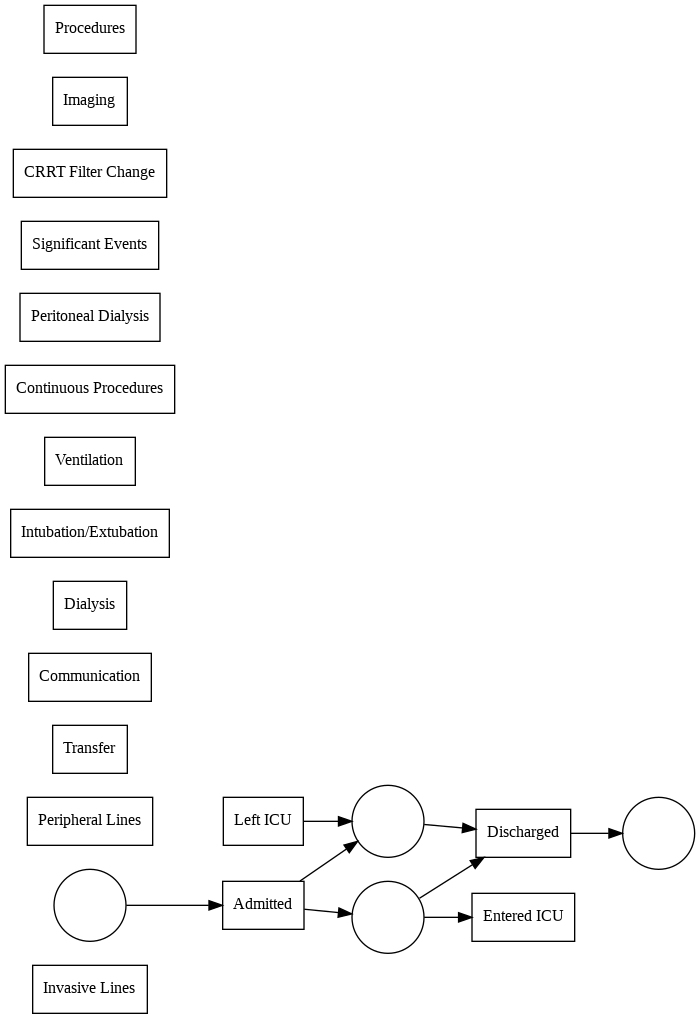

In [54]:
import graphviz
pm.view_petri_net(petri_net=net)

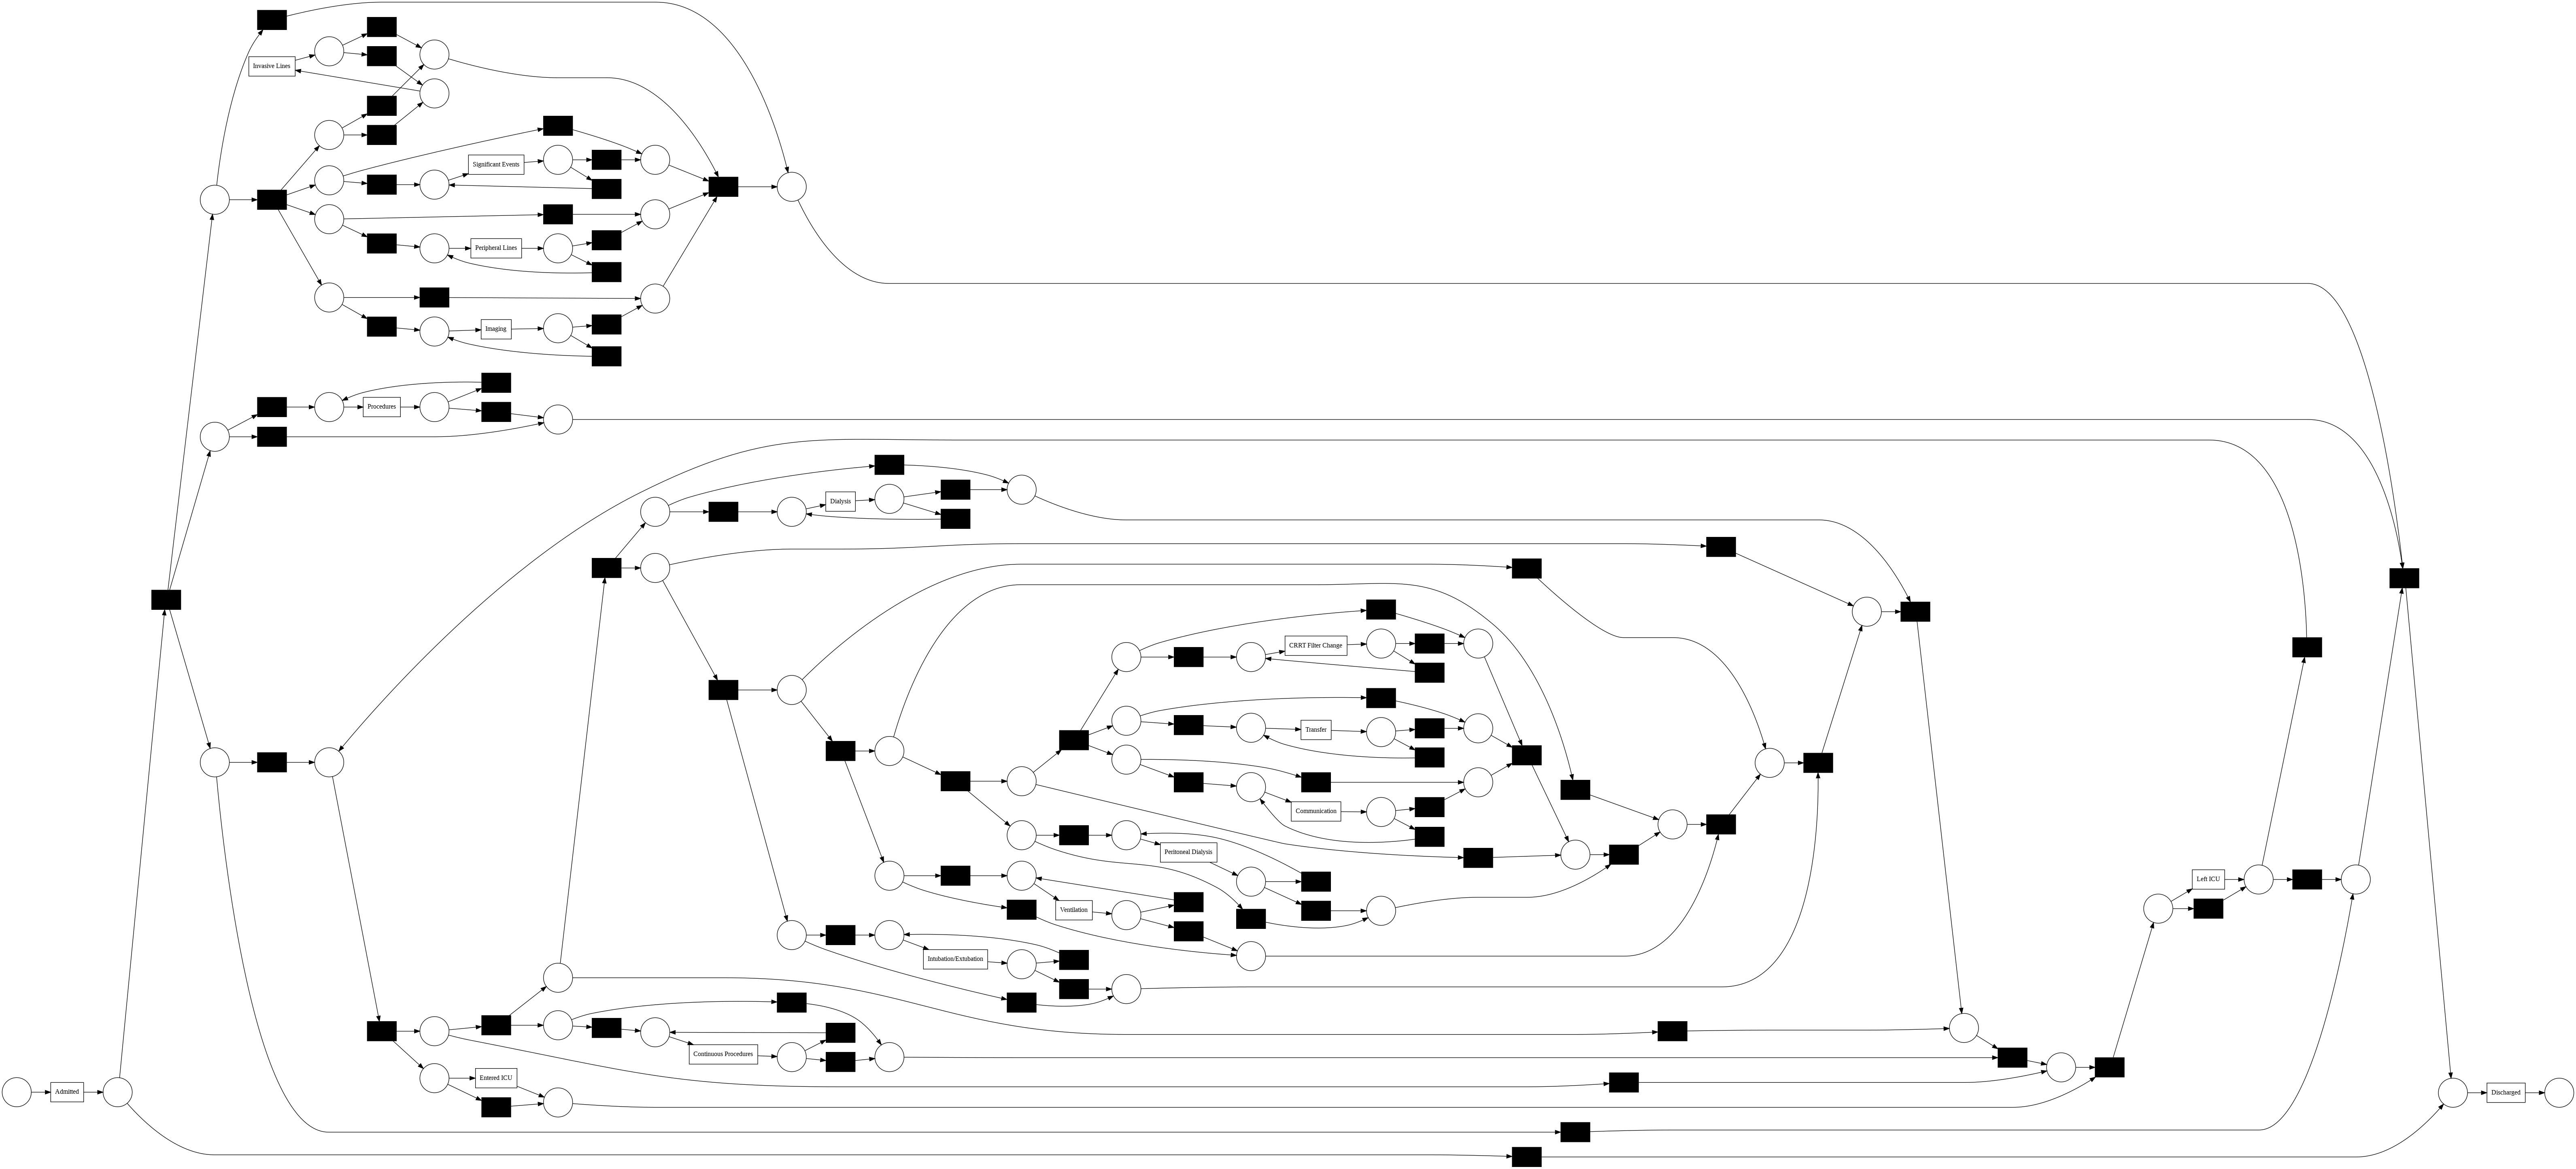

In [55]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

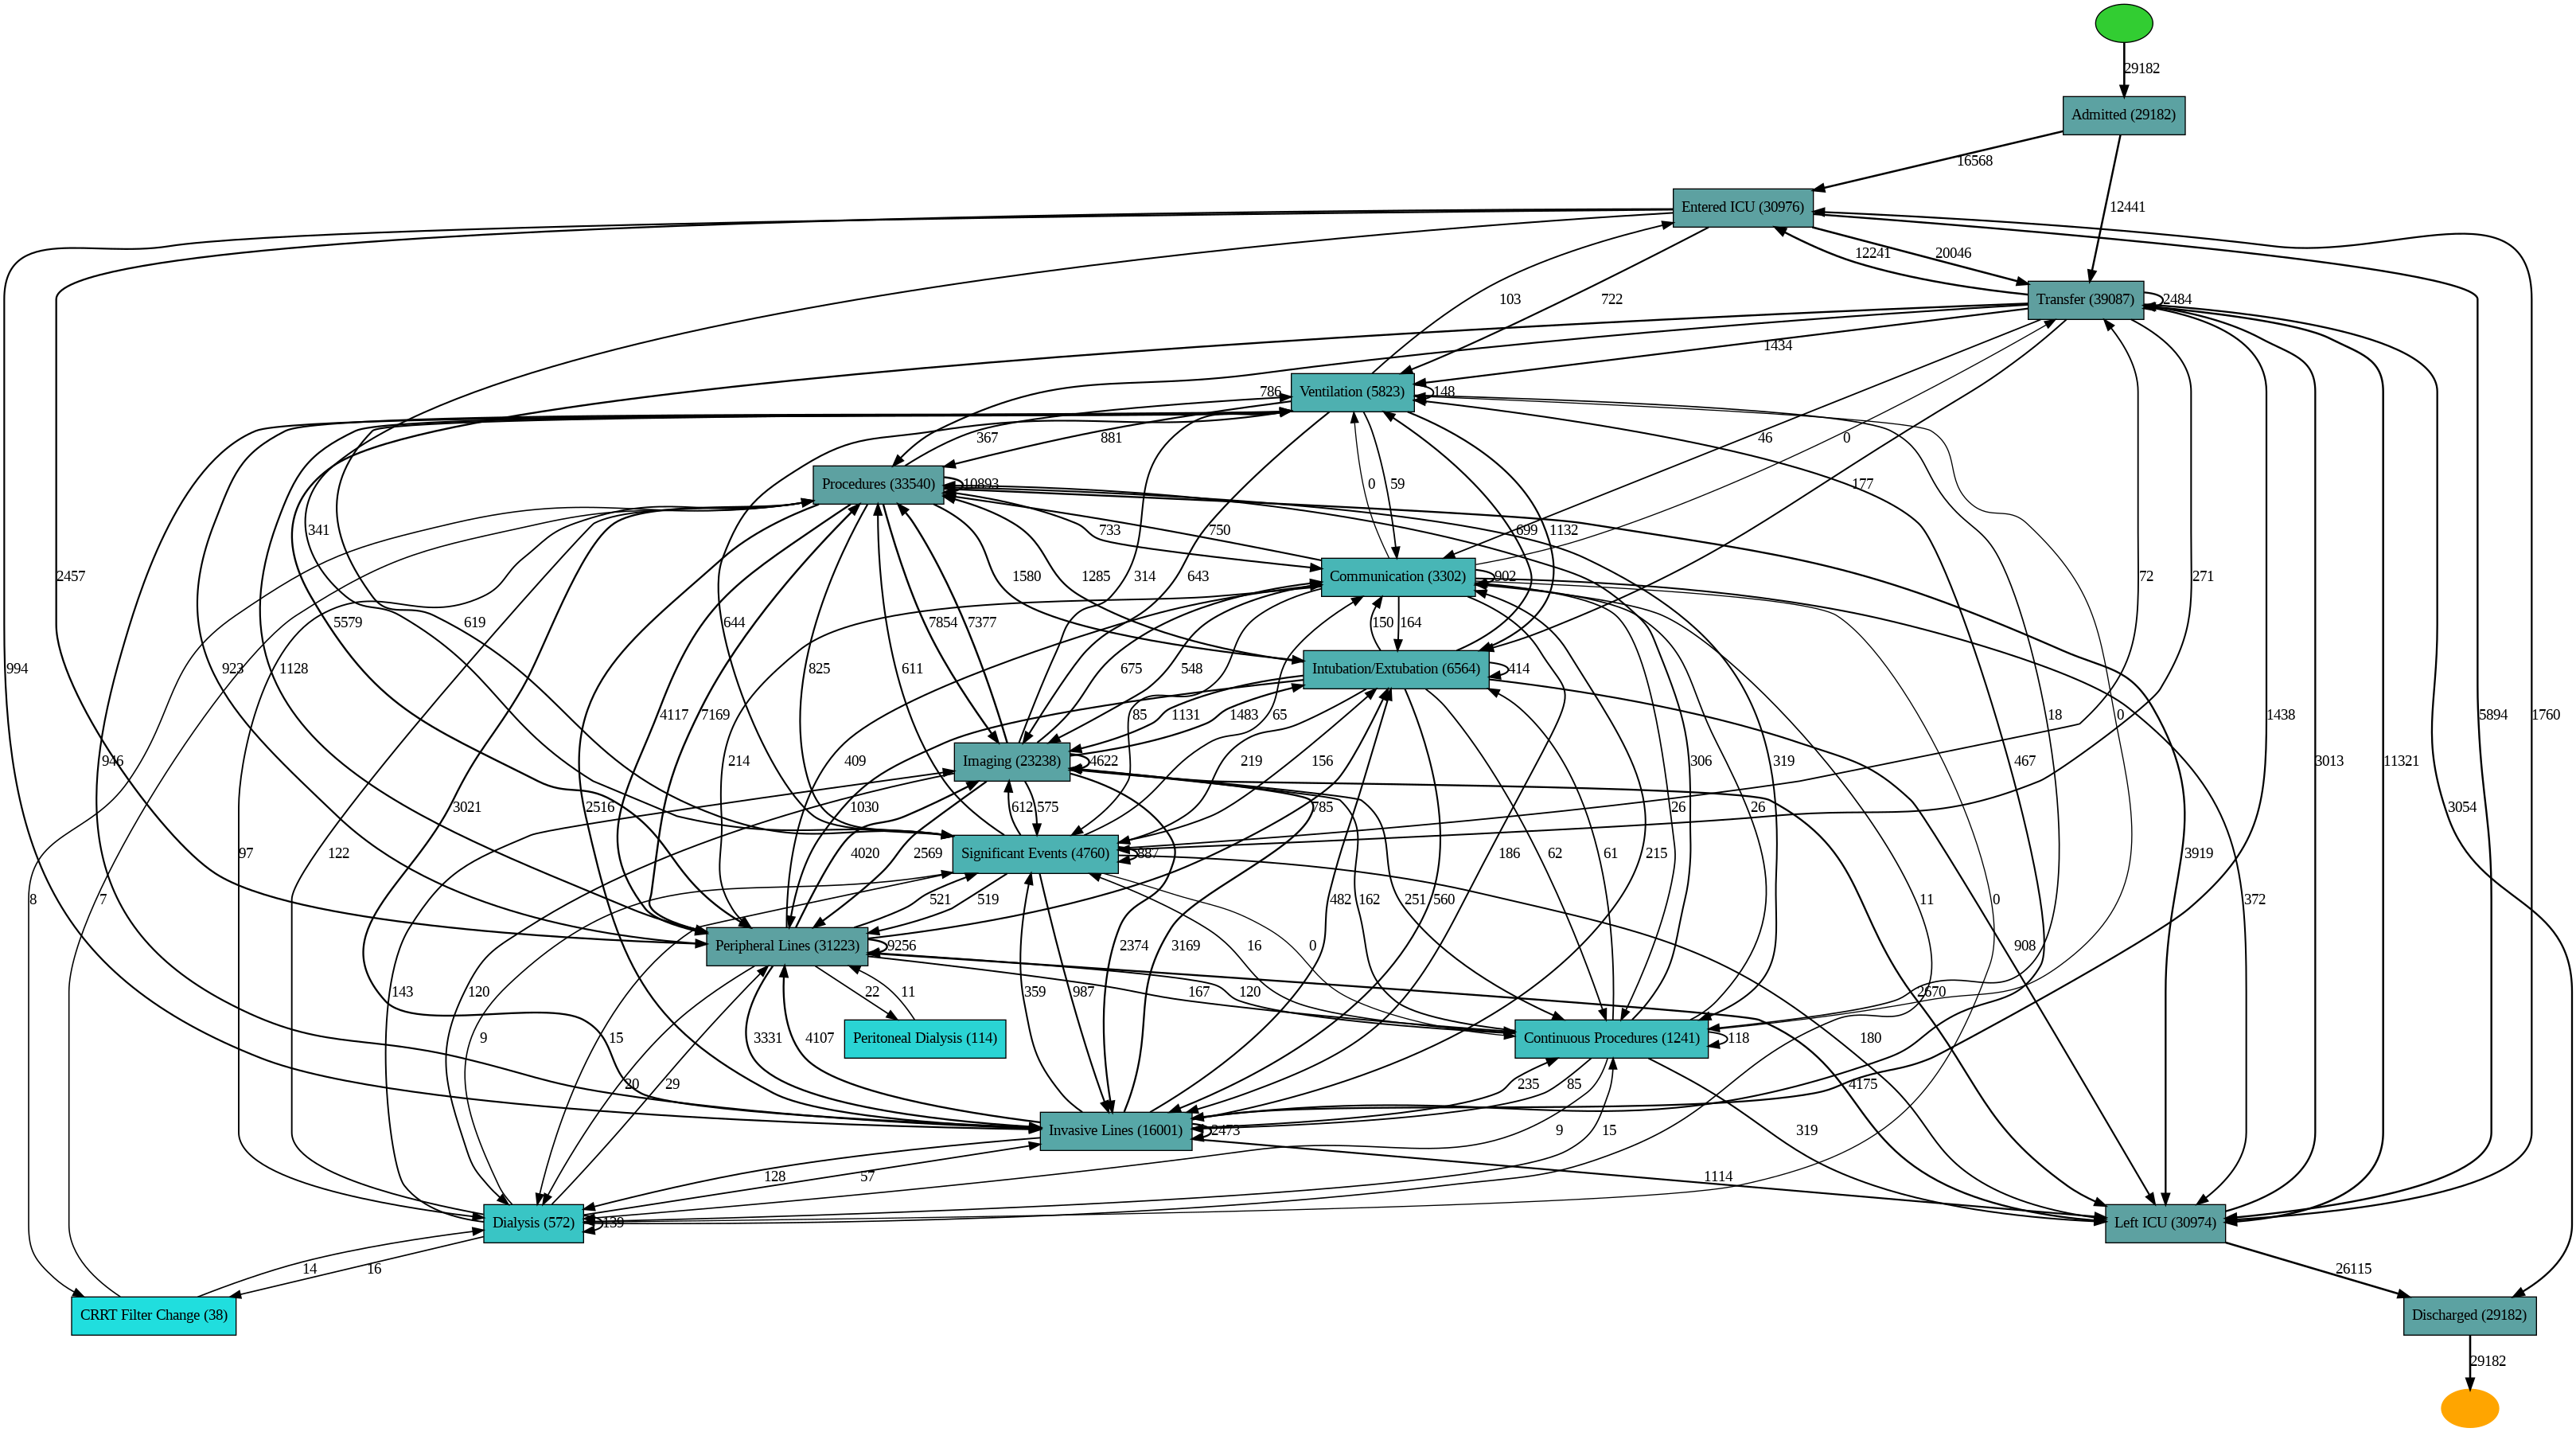

In [56]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

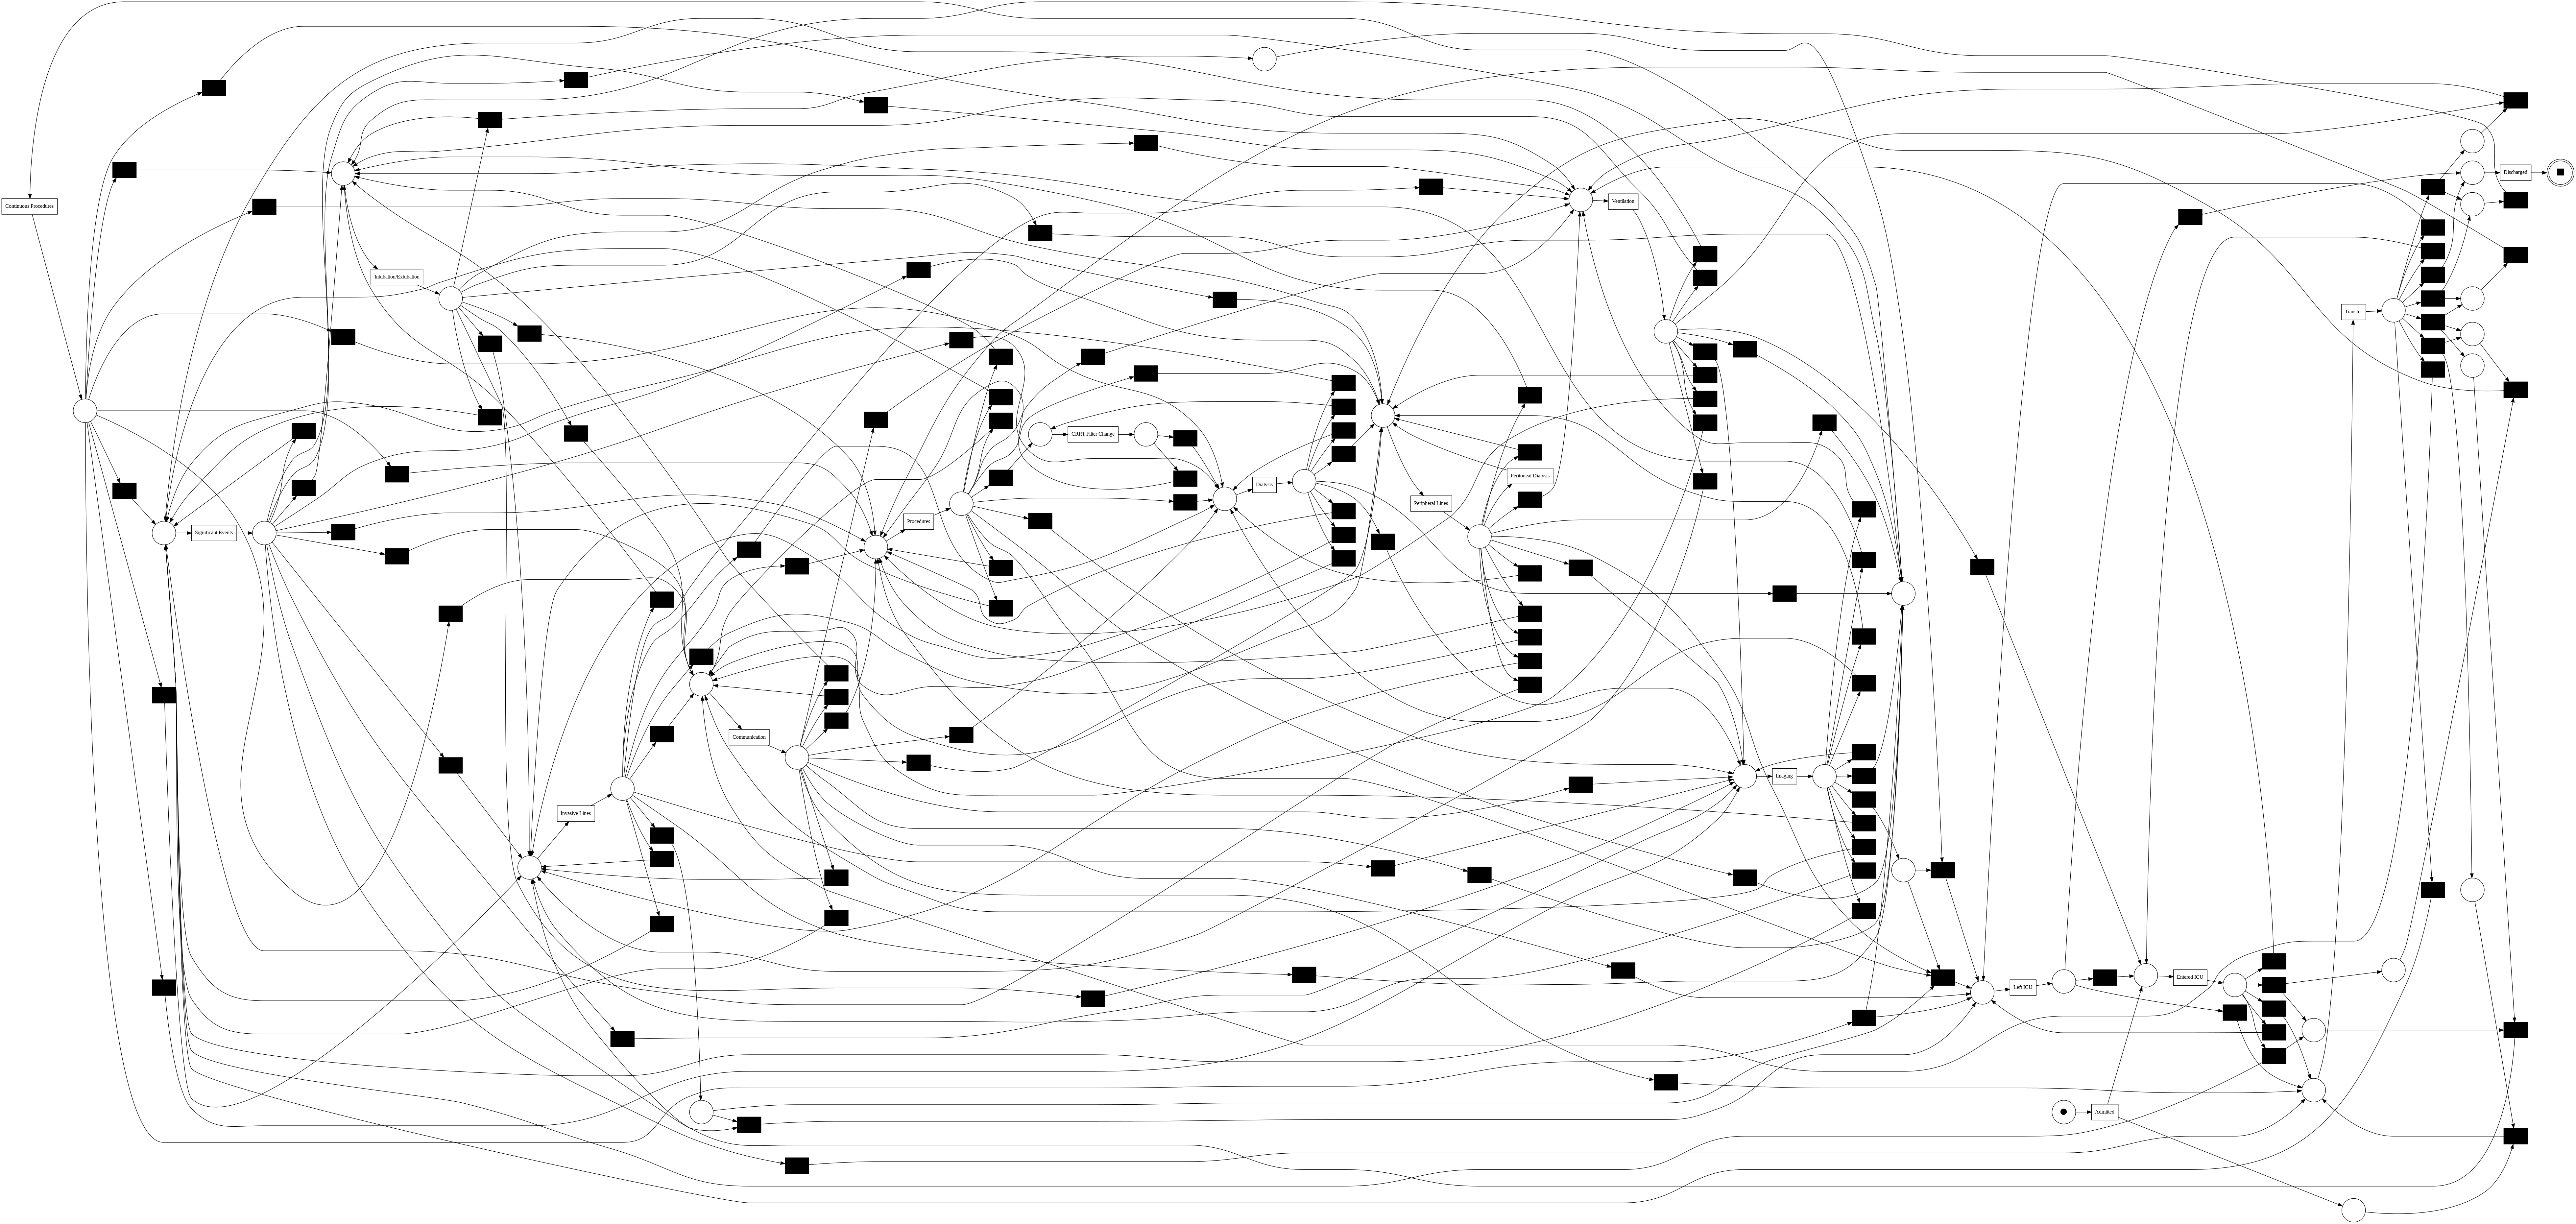

In [57]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [127]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [128]:
partial_el = partial_log(event_log, NUM_TRACES)
# partial_el

In [129]:
if QUERY_NAME != 'el_procedures_2.sql':
  CATEGORICAL_PROCEDURES = False

if CATEGORICAL_PROCEDURES == False:
    
  # lets represent each activity using a statically defined number
  # this will prevent the need for using an embedding layer when traing the LSTM
  unique_activities = partial_el['activity'].unique()
  n_activities = len(unique_activities) + 1
  encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

  # lets also create a second dictionary that will be used to decode predicted activities
  decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}

else:
  encode_activity = {
      'Admitted': '1',
      'Transfer': '2',
      'Entered ICU': '3',
      'Left ICU': '4',
      'Discharged': '5',
      'Peripheral Lines': '6',
      'Invasive Lines': '6',
      'Imaging': '7',
      'Ventilation': '8',
      'Intubation/Extubation': '8',
      'Procedures': '9',
      'Continuous Procedures': '9',
      'Significant Events': '10',
      'Dialysis': '11',
      'CRRT Filter Change': '11',
      'Peritoneal Dialysis': '11',
      'Communication': '12'
  }
  decode_activity = {}

encode_activity, decode_activity

({'Admitted': '1',
  'Entered ICU': '2',
  'Transfer': '3',
  'Peripheral Lines': '4',
  'Ventilation': '5',
  'Procedures': '6',
  'Imaging': '7',
  'Invasive Lines': '8',
  'Significant Events': '9',
  'Left ICU': '10',
  'Discharged': '11',
  'Intubation/Extubation': '12',
  'Continuous Procedures': '13',
  'Communication': '14',
  'Dialysis': '15'},
 {'1': 'Admitted',
  '2': 'Entered ICU',
  '3': 'Transfer',
  '4': 'Peripheral Lines',
  '5': 'Ventilation',
  '6': 'Procedures',
  '7': 'Imaging',
  '8': 'Invasive Lines',
  '9': 'Significant Events',
  '10': 'Left ICU',
  '11': 'Discharged',
  '12': 'Intubation/Extubation',
  '13': 'Continuous Procedures',
  '14': 'Communication',
  '15': 'Dialysis'})

In [130]:
# calculate time deltas for prefix and suffix sequences
def calculate_time_deltas(p, s):
  p_deltas, s_deltas = [], []
  f = '%Y-%d-%m %H:%M:%S'
  for i in range(PREFIX_LENGTH):
    if p[i] == '0' or p[i+1] == '0':
      p_deltas.append(0)

    else:
      delta = pd.to_datetime(p[i+1], format=f) - pd.to_datetime(p[i], format=f)
      p_deltas.append(delta.total_seconds())

  for i in range(PREFIX_LENGTH,0,-1):
    if s[i] == '0' or s[i-1] == '0':
      s_deltas.append(0)
    else:
      delta = pd.to_datetime(s[i], format=f) - pd.to_datetime(s[i-1], format=f)
      s_deltas.append(delta.total_seconds())
  
  return p_deltas, s_deltas[::-1]

In [131]:
import numpy as np

# create a new labeled data frame
def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr = [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)

    
    length = len(activities)
    
    for i in range(length):

      label = activities[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i+1]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]

      if i != length:
        suffix_times = timestamps[i:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH+1:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH +1:
        suffix_times.append('0')

      prefix_deltas, suffix_deltas = calculate_time_deltas(prefix_times, suffix_times)
      # print(f'prefix t: {prefix_times} \n suffix t: {suffix_times}')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_deltas))
      suffix_times_arr.append(np.array(suffix_deltas))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'label' : label_arr})
 

In [132]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


prefix             suffix  \
3025   [1, 3, 2, 7, 4]    [8, 4, 8, 8, 6]   
3308   [0, 0, 0, 1, 2]    [8, 4, 8, 6, 6]   
3996   [1, 3, 2, 9, 5]    [0, 0, 0, 0, 0]   
338    [1, 2, 3, 4, 6]   [7, 14, 6, 8, 8]   
978    [0, 0, 0, 1, 2]  [10, 11, 0, 0, 0]   
...                ...                ...   
1787   [0, 0, 0, 1, 2]  [10, 11, 0, 0, 0]   
6200  [1, 3, 2, 3, 14]    [0, 0, 0, 0, 0]   
501    [0, 1, 2, 3, 4]   [4, 4, 10, 3, 2]   
4444   [0, 0, 0, 0, 1]  [2, 3, 10, 11, 0]   
382    [0, 0, 0, 0, 0]  [3, 2, 10, 11, 0]   

                             prefix time delta  \
3025  [112.0, 2065501.0, 2587.0, 3420.0, 60.0]   
3308                [0.0, 0.0, 0.0, 90.0, 0.0]   
3996     [69.0, 74299.0, 4052.0, 120.0, 780.0]   
338       [110.0, 0.0, 4750.0, 360.0, 39900.0]   
978                [0.0, 0.0, 0.0, 120.0, 0.0]   
...                                        ...   
1787                [0.0, 0.0, 0.0, 79.0, 0.0]   
6200      [122.0, 89214.0, 18.0, 11506.0, 0.0]   
501          [0.0, 81.0, 0.0, 17739.0, 3600.0]   
4444               [0.0, 0.0, 0.0, 0.0, 198.0]   
382                            [0, 0, 0, 0, 0]   

                                    suffix time delta label  
3025                   [60.0, 0.0, 60.0, 60.0, 480.0]     4  
3308           [29790.0, 0.0, 300.0, 28620.0, 5280.0]     3  
3996                                  [0, 0, 0, 0, 0]    11  
338             [1800.0, 1200.0, 0.0, 5400.0, 1800.0]     6  
978               [226920.0, 703380.0, 0.0, 0.0, 0.0]     3  
...                                               ...   ...  
1787               [139051.0, 85930.0, 0.0, 0.0, 0.0]     3  
6200                                  [0, 0, 0, 0, 0]    11  
501   [10800.0, 136260.0, 21035.0, 28259.0, 290561.0]     5  
4444    [148310.0, 102852.0, 324299.0, 539981.0, 0.0]     3  
382          [43.0, 482613.0, 30319.0, 420325.0, 0.0]     1  

[5376 rows x 5 columns]

In [133]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [134]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(                prefix             suffix  \
 5869   [1, 3, 3, 2, 4]   [8, 7, 12, 9, 9]   
 407    [1, 2, 3, 5, 4]  [7, 10, 11, 0, 0]   
 1460   [0, 0, 0, 0, 1]   [3, 8, 4, 4, 10]   
 3815   [1, 2, 3, 5, 6]    [0, 0, 0, 0, 0]   
 2732   [1, 2, 3, 5, 4]   [7, 6, 4, 7, 10]   
 ...                ...                ...   
 425    [1, 2, 3, 4, 4]  [6, 6, 10, 11, 0]   
 2009   [1, 3, 2, 3, 5]    [4, 8, 6, 7, 6]   
 2266   [0, 0, 1, 2, 3]  [4, 7, 12, 7, 10]   
 3274  [0, 1, 2, 3, 10]   [11, 0, 0, 0, 0]   
 5414   [1, 2, 3, 5, 6]    [6, 6, 7, 8, 8]   
 
                              prefix time delta  \
 5869  [91.0, 66284.0, 4205.0, 2440.0, 49740.0]   
 407          [44.0, 0.0, 5656.0, 60.0, 9120.0]   
 1460                [0.0, 0.0, 0.0, 0.0, 96.0]   
 3815         [84.0, 0.0, 11616.0, 0.0, 3600.0]   
 2732       [81.0, 0.0, 1959.0, 4200.0, 5700.0]   
 ...                                        ...   
 425         [53.0, 0.0, 7327.0, 60.0, 41580.0]   
 2009       [94.0, 845737.0, 17.0, 123

In [135]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [136]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_td = np.array(el['prefix time delta'])
  prefix_td = np.stack(prefix_td)
  prefix_td = prefix_td.reshape(prefix_td.shape[0], prefix_td.shape[1], 1)

  suffix_td = np.array(el['suffix time delta'])
  suffix_td = np.stack(suffix_td)
  suffix_td = suffix_td.reshape(suffix_td.shape[0], suffix_td.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_td], [suffix_td]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y, n_activities)
    return x, y_encoded
  
  return x, y

In [137]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)
test_x


array([[[[1.00000e+00],
         [3.00000e+00],
         [3.00000e+00],
         [2.00000e+00],
         [4.00000e+00]],

        [[1.00000e+00],
         [2.00000e+00],
         [3.00000e+00],
         [5.00000e+00],
         [4.00000e+00]],

        [[0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [0.00000e+00],
         [1.00000e+00]],

        ...,

        [[0.00000e+00],
         [0.00000e+00],
         [1.00000e+00],
         [2.00000e+00],
         [3.00000e+00]],

        [[0.00000e+00],
         [1.00000e+00],
         [2.00000e+00],
         [3.00000e+00],
         [1.00000e+01]],

        [[1.00000e+00],
         [2.00000e+00],
         [3.00000e+00],
         [5.00000e+00],
         [6.00000e+00]]],


       [[[8.00000e+00],
         [7.00000e+00],
         [1.20000e+01],
         [9.00000e+00],
         [9.00000e+00]],

        [[7.00000e+00],
         [1.00000e+01],
         [1.10000e+01],
         [0.00000e+00],
         [0.00000e+00]],

        

## Section 4: Predicting Missing Activities using LSTM

###4.1 Prefix LSTM

In [ ]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


prefix_LSTM = Sequential()
prefix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
prefix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
prefix_LSTM.add(Dense(n_activities, activation='softmax'))

prefix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
prefix_LSTM.summary()
prefix_LSTM.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          850       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 17)                867       
                                                                 
Total params: 21,917
Trainable params: 21,917
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
137/137 [==============================] - 4s 11ms/step - loss: 2.1900 - accuracy: 0.2941 - val_loss: 1.6361 - val_accuracy: 0.4574
Epoch 2/10
137/137 [==============================] - 1s 7ms/step - loss: 1.5885 - accuracy: 0.4584 - val_loss: 1.5068 - val_accuracy: 0.4445
Epoch 3/10
137/137 [===========

###4.2 Suffix LSTM

In [ ]:
# backwards LSTM

suffix_LSTM = Sequential()
suffix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
suffix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
suffix_LSTM.add(Dense(n_activities, activation='softmax'))

suffix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
suffix_LSTM.summary()
suffix_LSTM.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          850       
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 17)                867       
                                                                 
Total params: 21,917
Trainable params: 21,917
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
137/137 [==============================] - 4s 8ms/step - loss: 2.1319 - accuracy: 0.3376 - val_loss: 1.4358 - val_accuracy: 0.4968
Epoch 2/10
137/137 [==============================] - 1s 7ms/step - loss: 1.3839 - accuracy: 0.5251 - val_loss: 1.2879 - val_accuracy: 0.5545
Epoch 3/10
137/137 [==========

###4.3 Bidirectional LSTM with activities

In [ ]:
from pandas.core.internals import concat
# Bidirectional LSTM
from keras.layers import Bidirectional, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 100)          20800       ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 100)          20800       ['suffix_input[0][0]']           
                                                                                            

###4.4 Bi-directional LSTM with time deltas 

In [ ]:
prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

td_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
td_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
td_LSTM.summary()
td_LSTM.fit((train_x[2], train_x[3]), train_y,  validation_data=((validation_x[2], validation_x[3]), validation_y), epochs=10)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 100)          20800       ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 100)          20800       ['suffix_input[0][0]']           
                                                                                            

###4.5 Bi-directional LSTM with both activities and timedeltas

####4.5.1 original architecture

In [109]:
# this LSTM takes additional two inputs:
# time deltas for the prefix events
# time deltas for the suffix events
from keras.layers import LSTM, Dense, Bidirectional, average, Input, concatenate
from keras import Model


prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')

merged_prefix = concatenate([prefix_events_input, prefix_deltas_input], axis=-1)
merged_suffix = concatenate([suffix_events_input, suffix_deltas_input], axis=-1)

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(merged_prefix)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(merged_suffix)

merged = average([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)

bi_LSTM_td.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td.summary()
bi_LSTM_td.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

####4.5.2 alternate architecture

In [113]:
from keras.layers import Dropout

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


lstm_layer = LSTM(100)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)


dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_deltas = Dropout(0.2)(prefix_deltas_lstm)
dropout_suffix_deltas = Dropout(0.2)(suffix_deltas_lstm)



merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td_2 = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)

bi_LSTM_td_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td_2.summary()
bi_LSTM_td_2.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

###4.6 Hyperparameter Tuning

In [138]:
import keras_tuner as kt

def build_model(hp):
  prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
  suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

  prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
  suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')


  lstm_units = hp.Int('units', min_value=32, max_value=512, step=32)
  lstm_layer = LSTM(lstm_units)

  prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
  suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
  prefix_deltas_lstm = Bidirectional(lstm_layer, name='prefix_deltas_lstm')(prefix_deltas_input)
  suffix_deltas_lstm = Bidirectional(lstm_layer, name='suffix_deltas_lstm')(suffix_deltas_input)

  dropout_rate_1 = hp.Choice('rate_1', values=[0.0,0.1,0.2,0.3,0.4,0.5])
  dropout_rate_2 = hp.Choice('rate_2', values=[0.0,0.1,0.2,0.3,0.4,0.5])
  dropout_rate_3 = hp.Choice('rate_3', values=[0.0,0.1,0.2,0.3,0.4,0.5])
  dropout_rate_4 = hp.Choice('rate_4', values=[0.0,0.1,0.2,0.3,0.4,0.5])


  dropout_prefix_events = Dropout(dropout_rate_1)(prefix_events_lstm)
  dropout_suffix_events = Dropout(dropout_rate_2)(suffix_events_lstm)
  dropout_prefix_deltas = Dropout(dropout_rate_3)(prefix_deltas_lstm)
  dropout_suffix_deltas = Dropout(dropout_rate_4)(suffix_deltas_lstm)



  merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_deltas, dropout_suffix_deltas], name='merged')

  output = Dense(n_activities, activation='softmax', name='output')(merged)

  model = Model(
      inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
      outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model
  
build_model(kt.HyperParameters())

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    seed=9,
    overwrite=True
)

tuner.search(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
    validation_y),
    epochs=10
)

Trial 5 Complete [00h 06m 43s]
val_accuracy: 0.6700743436813354

Best val_accuracy So Far: 0.6700743436813354
Total elapsed time: 00h 29m 58s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
288               |288               |units
0.3               |0.3               |rate_1
0.1               |0                 |rate_2
0.4               |0                 |rate_3
0.3               |0.3               |rate_4

Epoch 1/10
135/135 [==============================] - 59s 255ms/step - loss: 1.2922 - accuracy: 0.5888 - val_loss: 1.0957 - val_accuracy: 0.6301
Epoch 2/10
 28/135 [=====>........................] - ETA: 17s - loss: 0.9525 - accuracy: 0.6574

In [ ]:
best_model = tuner.get_best_models(num_models=1)
best_model.build()
best_model.summary()

##Section 5: Evaluation and Conformance Checking

In [94]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [ ]:
# prefix-LSTM
predictions_prefix = prefix_LSTM.predict(test_x[0])
evaluate(predictions_prefix)

43/43 [==============================] - 0s 3ms/step


0.4670087976539589

In [ ]:
# suffix-LSTM
predictions_suffix = suffix_LSTM.predict(test_x[1])
evaluate(predictions_suffix)

43/43 [==============================] - 0s 3ms/step


0.5681818181818182

In [ ]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions)

0.3350439882697947

In [ ]:
# bi-LSTM with time deltas
predictions_td = td_LSTM.predict([test_x[2], test_x[3]])
evaluate(predictions_td)

43/43 [==============================] - 0s 4ms/step


0.6466275659824047

In [ ]:
# bi-LSTM with activities
predictions_bi = bi_LSTM.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

43/43 [==============================] - 2s 5ms/step


0.6517595307917888

In [95]:
# bi-LSTM with activities and time deltas 1
predictions_bi_td = bi_LSTM_td.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td,verbose=True)

42/42 [==============================] - 3s 5ms/step
predicted : 6; expected : 4
predicted : 6; expected : 14
predicted : 6; expected : 7
predicted : 6; expected : 7
predicted : 8; expected : 4
predicted : 4; expected : 3
predicted : 6; expected : 7
predicted : 6; expected : 7
predicted : 6; expected : 8
predicted : 6; expected : 5
predicted : 6; expected : 4
predicted : 6; expected : 14
predicted : 6; expected : 14
predicted : 6; expected : 7
predicted : 6; expected : 12
predicted : 6; expected : 4
predicted : 6; expected : 5
predicted : 6; expected : 7
predicted : 6; expected : 12
predicted : 6; expected : 7
predicted : 4; expected : 8
predicted : 6; expected : 4
predicted : 6; expected : 8
predicted : 6; expected : 7
predicted : 6; expected : 4
predicted : 6; expected : 4
predicted : 6; expected : 4
predicted : 6; expected : 7
predicted : 7; expected : 4
predicted : 7; expected : 6
predicted : 6; expected : 7
predicted : 6; expected : 4
predicted : 6; expected : 4
predicted : 6; exp

0.6644345238095238

In [112]:
# bi-LSTM with activities and time deltas 2
predictions_bi_td_2 = bi_LSTM_td_2.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td_2,verbose=False)

378/378 [==============================] - 10s 26ms/step


0.6872002645940135